In [3]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [4]:
def compute_mean_std(loader):
    mean = 0.0
    var = 0.0
    for images, _ in loader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        var += images.var(2).sum(0)

    mean /= len(loader.dataset)
    var /= len(loader.dataset)
    std = torch.sqrt(var)

    return mean, std

# Load the dataset without any normalization transforms
train_dataset_example = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(train_dataset_example, batch_size=128, num_workers=1, shuffle=True)

# Now compute the mean and standard deviation
mean, std = compute_mean_std(loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 2640397119/2640397119 [05:31<00:00, 7958511.19it/s] 


Extracting ./data/stl10_binary.tar.gz to ./data


Mean: tensor([0.4467, 0.4398, 0.4066])
Std: tensor([0.2326, 0.2300, 0.2343])


In [4]:
mean, std = (0.44, 0.44, 0.44), (0.23, 0.23, 0.23)
#mean, std = (0.1, 0.1, 0.1), (0.85, 0.85, 0.85)
train_transform=transforms.Compose([
        transforms.RandomCrop((64, 64)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
        ])
test_transform=transforms.Compose([
        transforms.CenterCrop(size=(64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
        ])

train_dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
val_dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=test_transform)
test_dataset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=test_transform)





100%|██████████| 2640397119/2640397119 [01:51<00:00, 23638362.97it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


## Visualize the Data Before Augmentation

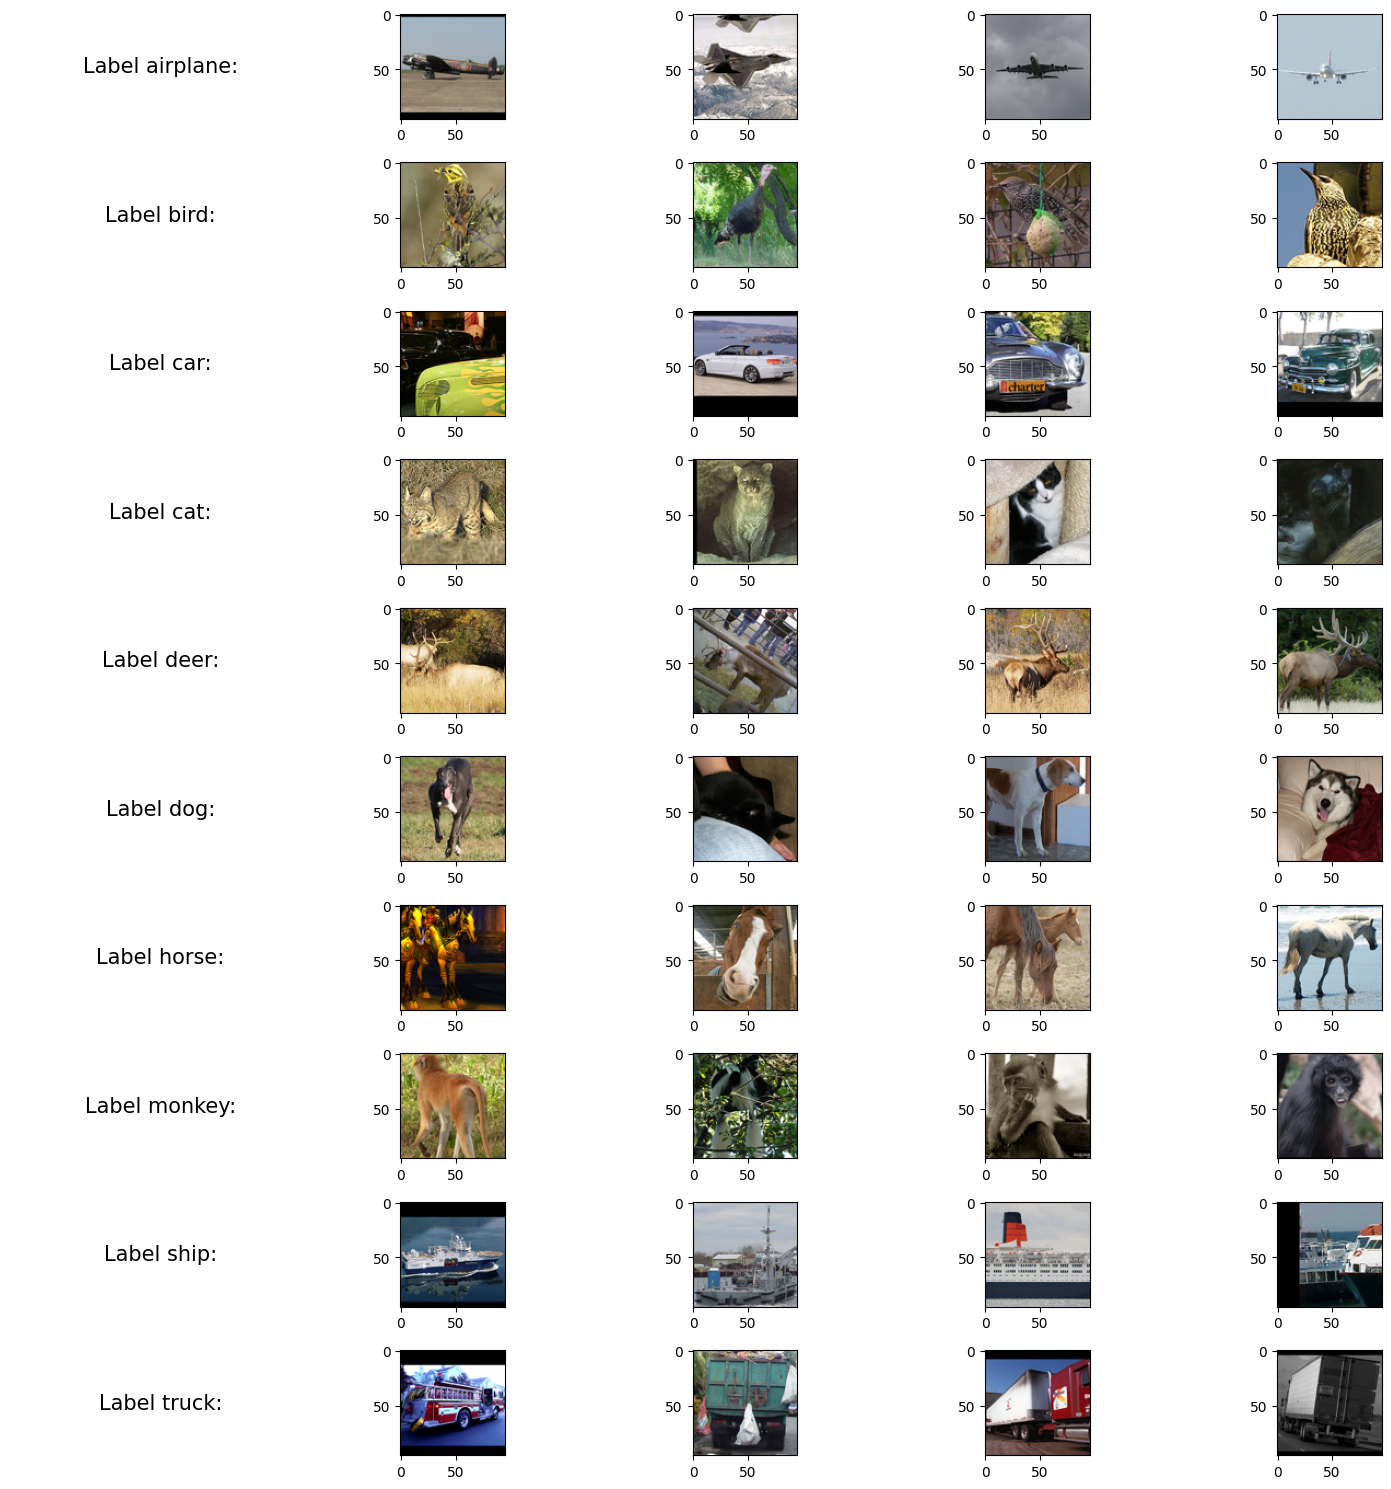

In [5]:

def print_examples_before(dataset, num_of_classes=10, num_of_examples=4):
    fig, axes = plt.subplots(num_of_classes, num_of_examples + 1, figsize=(15, 15))

    for i in range(num_of_classes):
        axes[i, 0].text(0.5, 0.5, f'Label {dataset.classes[i]}:', horizontalalignment='center', verticalalignment='center', fontsize=15, color='black')
        axes[i, 0].axis('off')
        indices_of_class = [idx for idx, label in enumerate(dataset.labels) if label == i][:num_of_examples]

        for j, idx in enumerate(indices_of_class):
            img = dataset.data[idx]
            ax = axes[i, j + 1]
            ax.imshow(img.transpose(1,2,0))

    plt.tight_layout()
    plt.show()



print_examples_before(train_dataset)

## Visualize the Data After Augmentation

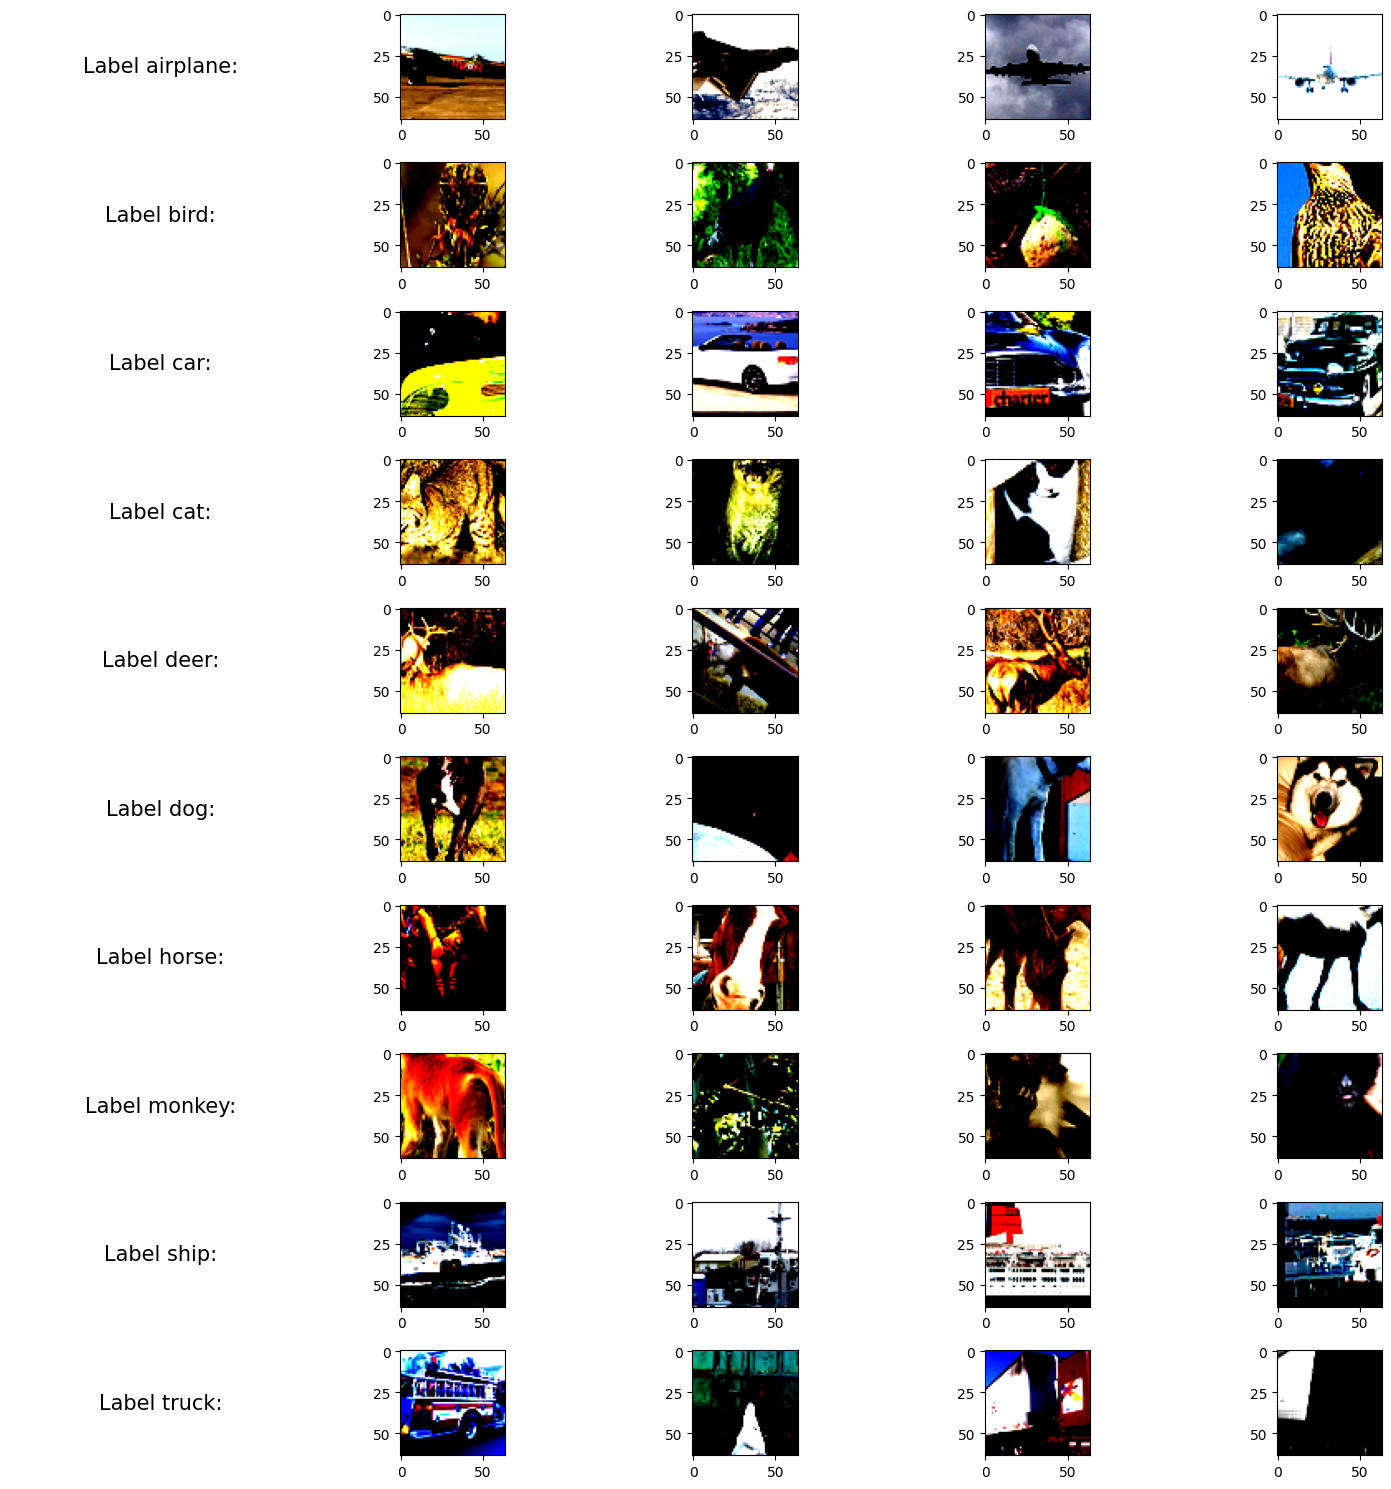

In [6]:

def print_examples_after(dataset, num_of_classes=10, num_of_examples=4):
    fig, axes = plt.subplots(num_of_classes, num_of_examples + 1, figsize=(15, 15))

    for i in range(num_of_classes):
        axes[i, 0].text(0.5, 0.5, f'Label {dataset.classes[i]}:', horizontalalignment='center', verticalalignment='center', fontsize=15, color='black')
        axes[i, 0].axis('off')

        class_indices = [idx for idx, (_, label) in enumerate(dataset) if label == i][:num_of_examples]

        for j, idx in enumerate(class_indices):
            img, label = dataset[idx]
            ax = axes[i, j + 1]
            img_numpy = np.transpose(img.numpy(), (1, 2, 0))
            ax.imshow(img_numpy)
    plt.tight_layout()
    plt.show()



print_examples_after(val_dataset)

In [7]:
batch_size = 128
test_batch_size = 128
epochs = 200
lr = 0.01
cuda = True
seed = 42
optimizer_type = 'SGD'
momentum = 0.0
weight_decay = 1e-4

use_cuda = cuda and torch.cuda.is_available()

# Set seed
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# Handel GPU stochasticity
torch.backends.cudnn.enabled = use_cuda
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if use_cuda else "cpu")
#device='cpu'
print(torch.cuda.is_available())

True


In [8]:
total_train_samples = len(train_dataset)
val_size = 0.2
num_val_samples = int(np.floor(val_size * total_train_samples))
num_train_samples = total_train_samples - num_val_samples

# Generate shuffled indices for train/validation split
indices = np.arange(total_train_samples)
np.random.shuffle(indices)
train_indices, val_indices = indices[num_val_samples:], indices[:num_val_samples]


train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Create DataLoader instances for each dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

## Models

In [9]:

class BaseModel(nn.Module):
    def __init__(self, lr=0.01, weight_decay=0.0, optimizer_type='SGD', momentum=0.9,device='cpu'):
        super(BaseModel,self).__init__()
        self.criterion=nn.CrossEntropyLoss()
        self.optimizer_type=optimizer_type
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.device=device

    def set_optimizer(self):

        if self.optimizer_type == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif self.optimizer_type == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_type == 'RMSProp':
            self.optimizer = optim.RMSprop(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise NotImplementedError(f"{self.optimizer_type} optimizer not implemented")


    def train_model(self, train_loader, val_loader=None):
        self.train()
        total_loss = 0
        train_acc=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            self.optimizer.zero_grad()
            logits = self.forward(data)
            loss = self.criterion(logits, target)
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_acc += (preds == target).float().mean().item()
            loss.backward()
            self.optimizer.step()


        total_loss /= len(train_loader)
        train_acc /= len(train_loader)

        val_loss = None
        if val_loader is not None:
            val_loss,val_acc = self.validate(val_loader)

        return total_loss, val_loss,train_acc,val_acc


    def validate(self, val_loader):
        self.eval()
        val_loss = 0
        val_acc=0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                logits = self.forward(data)
                loss = self.criterion(logits, target)
                preds = logits.argmax(dim=1)
                val_acc += (preds == target).float().mean().item()
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        return val_loss,val_acc

    def fit(self, train_loader,nr_epochs, val_loader=None,verbose=True, print_interval=100, shuffle=True):
        train_losses, train_accuracy, val_losses, val_accuracy = ([] for i in range(4))

        for epoch in range(nr_epochs):
            train_loss, val_loss,train_acc,val_acc = self.train_model(train_loader, val_loader)  # Training and validation in one call
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracy.append(train_acc)
            val_accuracy.append(val_acc)

            if verbose and (epoch + 1) % print_interval == 0:
                message = f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}'
                if val_loss is not None : print(message + f', Val Loss: {val_loss:.4f}')
                else: print(message)
        return train_losses,val_losses,train_accuracy,val_accuracy


    def test(self, test_loader):
      self.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for data, labels in test_loader:
              data, labels = data.to(self.device), labels.to(self.device)
              logits = self.forward(data)
              predictions = logits.argmax(dim=1)
              correct += (predictions == labels).sum().item()
              total += labels.size(0)

      test_acc = correct / total
      return test_acc




class LogisticRegression(BaseModel):
    def __init__(self, input_dim=64*64*3,num_class=10, optimizer_type='SGD',weight_decay=0.0, lr=0.01,device='cpu'):
        super(LogisticRegression, self).__init__(lr=lr, weight_decay=weight_decay, optimizer_type=optimizer_type,device=device)
        self.flat=nn.Flatten(start_dim=1)
        self.linear = nn.Linear(input_dim,num_class)
        self.set_optimizer()



    def forward(self, x):
        x=self.flat(x)
        x=self.linear(x)
        return x


class FCNN (BaseModel):
    def __init__(self,input_dim=64*64*3,layer_size=256,num_class=10,num_hidden=3,optimizer_type='SGD',weight_decay=0.0, lr=0.01,device='cpu'):
        super(FCNN,self).__init__(lr=lr, weight_decay=weight_decay, optimizer_type=optimizer_type,device=device)
        self.flat=nn.Flatten(start_dim=1)
        self.hidden_layers=nn.ModuleList()
        self.hidden_layers.append(nn.Sequential(
                nn.Linear(input_dim,128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(p=0.5))
                )
        for i in range(1,num_hidden):
            if i==num_hidden-1:
                   self.hidden_layers.append(nn.Sequential(
                            nn.Linear(128,64),
                            nn.ReLU(),
                            nn.BatchNorm1d(64),
                            nn.Dropout(p=0.5))
                   )
            else:
                   self.hidden_layers.append(nn.Sequential(
                            nn.Linear(128,128),
                            nn.ReLU(),
                            nn.BatchNorm1d(128),
                            nn.Dropout(p=0.5))
                   )
        self.out = nn.Linear(64, num_class)
        self.set_optimizer()

    def forward(self,x):
        x=self.flat(x)
        for layer in self.hidden_layers:
             x=layer(x)
        x=self.out(x)
        return x


class CNN (BaseModel):
    def __init__(self,input_dim=64,num_channels=3,kernel_size=5,optimizer_type='SGD',weight_decay=0.0, lr=0.01,device='cpu'):
        super(CNN,self).__init__(lr=lr, weight_decay=weight_decay, optimizer_type=optimizer_type,device=device)
        self.conv1=nn.Conv2d(3,8,3)
        self.bn1=nn.BatchNorm2d(8)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(8,32,3)
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,3)
        self.bn3=nn.BatchNorm2d(64)
        self.lin=nn.Linear(64*6*6,64)
        self.drop=nn.Dropout(p=0.5)
        self.out=nn.Linear(64,10)
        self.set_optimizer()

    def forward(self,x):
        x=self.bn1(F.relu(self.conv1(x)))
        x=self.pool(x)
        x=self.bn2(F.relu(self.conv2(x)))
        x=self.pool(x)
        x=self.bn3(F.relu(self.conv3(x)))
        x=self.pool(x)
        x = x.view(-1, 64 * 6 * 6)
        x=self.drop(F.relu(self.lin(x)))
        x=self.out(x)
        return x


class MobileNetV2_NoGrad(BaseModel):
    def __init__(self,optimizer_type='SGD',weight_decay=0.0, lr=0.01,device='cpu'):
        super(MobileNetV2_NoGrad, self).__init__(lr=lr, weight_decay=weight_decay, optimizer_type=optimizer_type,device=device)
        self.feature_extractor = models.mobilenet_v2(pretrained=True)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.drop = nn.Dropout(p=0.5)
        self.lin1 = nn.Linear(self.feature_extractor.classifier[1].out_features, 512)
        self.lin2 = nn.Linear(512, 64)
        self.out = nn.Linear(64, 10)
        self.set_optimizer()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.drop(F.relu(x))
        x = self.drop(F.relu(self.lin1(x)))
        x = self.drop(F.relu(self.lin2(x)))
        x=self.out(x)
        return x



class MobileNetV2_UpdateGrad(BaseModel):
    def __init__(self,optimizer_type='SGD',weight_decay=0.0, lr=0.01,device='cpu'):
        super(MobileNetV2_UpdateGrad, self).__init__(lr=lr, weight_decay=weight_decay, optimizer_type=optimizer_type,device=device)
        self.feature_extractor = models.mobilenet_v2(models.MobileNet_V2_Weights.DEFAULT)
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
        self.drop = nn.Dropout(p=0.5)
        self.lin1 = nn.Linear(self.feature_extractor.classifier[1].out_features, 512)
        self.lin2 = nn.Linear(512, 64)
        self.out = nn.Linear(64, 10)
        self.set_optimizer()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.drop(F.relu(x))
        x = self.drop(F.relu(self.lin1(x)))
        x = self.drop(F.relu(self.lin2(x)))
        x=self.out(x)
        return x


In [10]:
def plotTrace(train_losses,val_losses,train_acc,val_acc,lr,weight_decay,model_name,epochs=100):
  steps = np.arange(epochs)

  fig, ax1 = plt.subplots()

  title_text = f"{model_name} - LR: {lr}, Weight Decay: {weight_decay}"
  fig.suptitle(title_text)

  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  #ax1.set_title('test loss: %.3f, test accuracy: %.3f' % (test_loss, test_acc))
  ax1.plot(steps, train_losses, label="train loss", color='red')
  ax1.plot(steps, val_losses, label="val loss", color='green')

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  ax2.set_ylabel('acccuracy')  # we already handled the x-label with ax1
  ax2.plot(steps, val_acc, label="val acc", color='blue')
  ax2.plot(steps, train_acc, label="train acc", color='yellow')

  fig.legend()
  fig.tight_layout()
  plt.show()

Epoch 10: Train Loss: 2.1747, Val Loss: 2.0268
Epoch 20: Train Loss: 2.1893, Val Loss: 2.0635
Epoch 30: Train Loss: 2.1741, Val Loss: 2.0321
Epoch 40: Train Loss: 2.1401, Val Loss: 1.9919
Epoch 50: Train Loss: 2.1406, Val Loss: 2.0496
Epoch 60: Train Loss: 2.1639, Val Loss: 2.0144
Epoch 70: Train Loss: 2.1460, Val Loss: 2.0444
Epoch 80: Train Loss: 2.1419, Val Loss: 2.0437
Epoch 90: Train Loss: 2.1366, Val Loss: 2.0038
Epoch 100: Train Loss: 2.1623, Val Loss: 2.0390


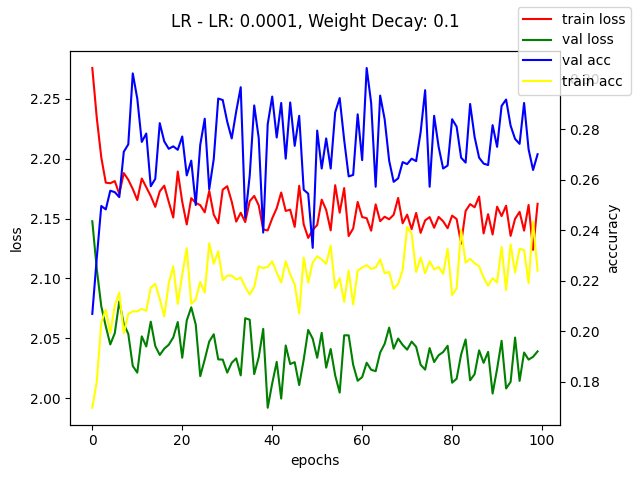

Validation Accuracy: 0.27011718787252903
Test Accuracy: 0.281875


In [15]:
model=LogisticRegression(lr=0.0001,optimizer_type='SGD',weight_decay=0.0005,device=device)
model.to(device)
train_losses,val_losses,train_acc,val_acc=model.fit(train_loader=train_loader,nr_epochs=100,val_loader=val_loader,verbose=True,print_interval=10)
plotTrace(train_losses,val_losses,train_acc,val_acc,0.0001,0.1,'LR',100)
print(f'Validation Accuracy: {val_acc[-1]}')
test_acc=model.test(test_loader)
print(f'Test Accuracy: {test_acc}')

Epoch 10: Train Loss: 2.1710, Val Loss: 1.9980
Epoch 20: Train Loss: 2.1173, Val Loss: 1.9646
Epoch 30: Train Loss: 2.0899, Val Loss: 1.9089
Epoch 40: Train Loss: 2.0631, Val Loss: 1.8954
Epoch 50: Train Loss: 2.0525, Val Loss: 1.8590
Epoch 60: Train Loss: 2.0563, Val Loss: 1.8465
Epoch 70: Train Loss: 2.0428, Val Loss: 1.8446
Epoch 80: Train Loss: 2.0414, Val Loss: 1.8369
Epoch 90: Train Loss: 2.0151, Val Loss: 1.8142
Epoch 100: Train Loss: 2.0292, Val Loss: 1.8145
Epoch 110: Train Loss: 2.0104, Val Loss: 1.8002
Epoch 120: Train Loss: 2.0083, Val Loss: 1.8021
Epoch 130: Train Loss: 2.0063, Val Loss: 1.7855
Epoch 140: Train Loss: 1.9902, Val Loss: 1.7668
Epoch 150: Train Loss: 2.0042, Val Loss: 1.7819
Epoch 160: Train Loss: 2.0127, Val Loss: 1.7774
Epoch 170: Train Loss: 1.9951, Val Loss: 1.7662
Epoch 180: Train Loss: 2.0002, Val Loss: 1.7685
Epoch 190: Train Loss: 1.9941, Val Loss: 1.7561
Epoch 200: Train Loss: 1.9767, Val Loss: 1.7476


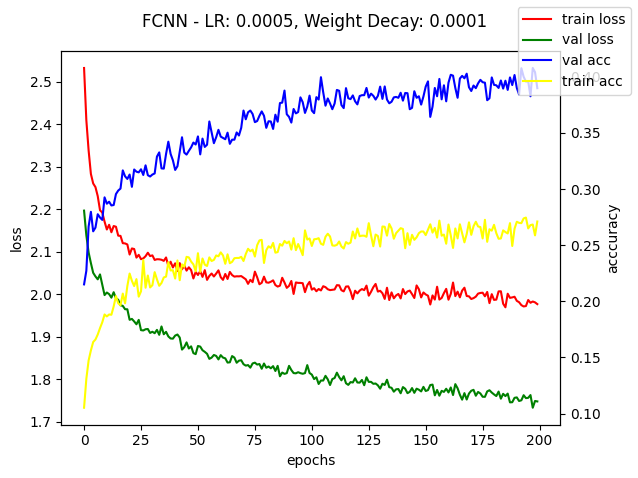

Validation Accuracy: 0.38984375074505806
Test Accuracy: 0.384625


In [14]:
model=FCNN(lr=0.0005,num_hidden=3,optimizer_type='Adam',weight_decay=0.0001,device=device)
model.to(device)
train_losses,val_losses,train_acc,val_acc=model.fit(train_loader=train_loader,nr_epochs=epochs,val_loader=val_loader,verbose=True,print_interval=10)
plotTrace(train_losses,val_losses,train_acc,val_acc,0.0005,0.0001,'FCNN',epochs)
print(f'Validation Accuracy: {val_acc[-1]}')
test_acc=model.test(test_loader)
print(f'Test Accuracy: {test_acc}')

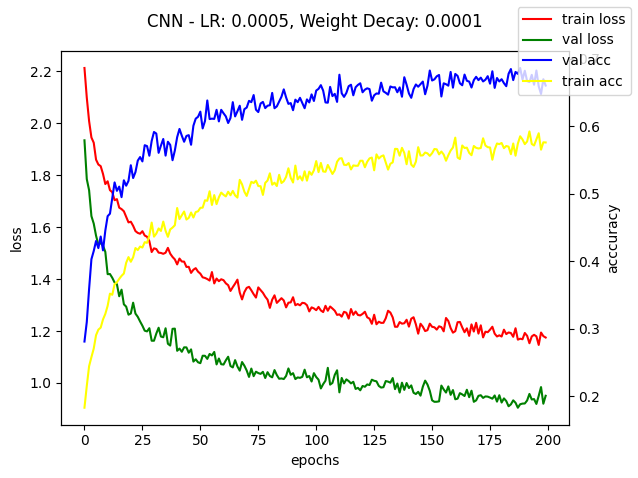

Validation Accuracy: 0.66015625


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy: 0.648625


In [65]:
model=CNN(lr=0.0005,optimizer_type='Adam',weight_decay=0.0001,device=device)
model.to(device)
train_losses,val_losses,train_acc,val_acc=model.fit(train_loader=train_loader,nr_epochs=epochs,val_loader=val_loader,verbose=True,print_interval=10)
plotTrace(train_losses,val_losses,train_acc,val_acc,0.0005,0.0001,'CNN',200)
print(f'Validation Accuracy: {val_acc[-1]}')
test_acc=model.test(test_loader)
print(f'Test Accuracy: {test_acc}')

Epoch 10: Train Loss: 1.7926, Val Loss: 1.3301
Epoch 20: Train Loss: 1.6608, Val Loss: 1.1950
Epoch 30: Train Loss: 1.6109, Val Loss: 1.1301
Epoch 40: Train Loss: 1.5731, Val Loss: 1.0692
Epoch 50: Train Loss: 1.5100, Val Loss: 1.0390
Epoch 60: Train Loss: 1.5123, Val Loss: 1.0421
Epoch 70: Train Loss: 1.4757, Val Loss: 1.0212
Epoch 80: Train Loss: 1.4708, Val Loss: 1.0080
Epoch 90: Train Loss: 1.4684, Val Loss: 0.9917
Epoch 100: Train Loss: 1.4523, Val Loss: 0.9843
Epoch 110: Train Loss: 1.4679, Val Loss: 0.9687
Epoch 120: Train Loss: 1.4485, Val Loss: 0.9861
Epoch 130: Train Loss: 1.4336, Val Loss: 0.9651
Epoch 140: Train Loss: 1.4535, Val Loss: 0.9601
Epoch 150: Train Loss: 1.4180, Val Loss: 0.9278
Epoch 160: Train Loss: 1.4311, Val Loss: 0.9657
Epoch 170: Train Loss: 1.4148, Val Loss: 0.9410
Epoch 180: Train Loss: 1.3785, Val Loss: 0.9290
Epoch 190: Train Loss: 1.4447, Val Loss: 0.9659
Epoch 200: Train Loss: 1.4202, Val Loss: 0.9342


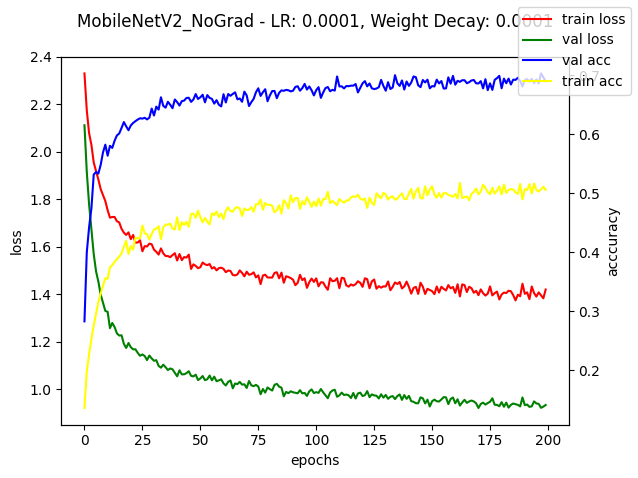

Validation Accuracy: 0.6898437514901161
Test Accuracy: 0.695125


In [70]:
model=MobileNetV2_NoGrad(lr=0.0001,optimizer_type='Adam',weight_decay=0.0001,device=device)
model.to(device)
train_losses,val_losses,train_acc,val_acc=model.fit(train_loader=train_loader,nr_epochs=200,val_loader=val_loader,verbose=True,print_interval=10)
plotTrace(train_losses,val_losses,train_acc,val_acc,0.0001,0.0001,'MobileNetV2_NoGrad',200)
print(f'Validation Accuracy: {val_acc[-1]}')
test_acc=model.test(test_loader)
print(f'Test Accuracy: {test_acc}')

Epoch 10: Train Loss: 0.7673, Val Loss: 0.4827
Epoch 20: Train Loss: 0.5724, Val Loss: 0.4343
Epoch 30: Train Loss: 0.4914, Val Loss: 0.4395
Epoch 40: Train Loss: 0.4511, Val Loss: 0.4254
Epoch 50: Train Loss: 0.3261, Val Loss: 0.4351
Epoch 60: Train Loss: 0.3381, Val Loss: 0.4176
Epoch 70: Train Loss: 0.3169, Val Loss: 0.4324
Epoch 80: Train Loss: 0.2783, Val Loss: 0.4573
Epoch 90: Train Loss: 0.2582, Val Loss: 0.4520
Epoch 100: Train Loss: 0.2327, Val Loss: 0.4628
Epoch 110: Train Loss: 0.2434, Val Loss: 0.4398
Epoch 120: Train Loss: 0.2181, Val Loss: 0.4491
Epoch 130: Train Loss: 0.2154, Val Loss: 0.4540
Epoch 140: Train Loss: 0.2125, Val Loss: 0.4682
Epoch 150: Train Loss: 0.1892, Val Loss: 0.5051
Epoch 160: Train Loss: 0.1933, Val Loss: 0.4588
Epoch 170: Train Loss: 0.2116, Val Loss: 0.5000
Epoch 180: Train Loss: 0.1527, Val Loss: 0.4944
Epoch 190: Train Loss: 0.1741, Val Loss: 0.5412
Epoch 200: Train Loss: 0.1495, Val Loss: 0.5805


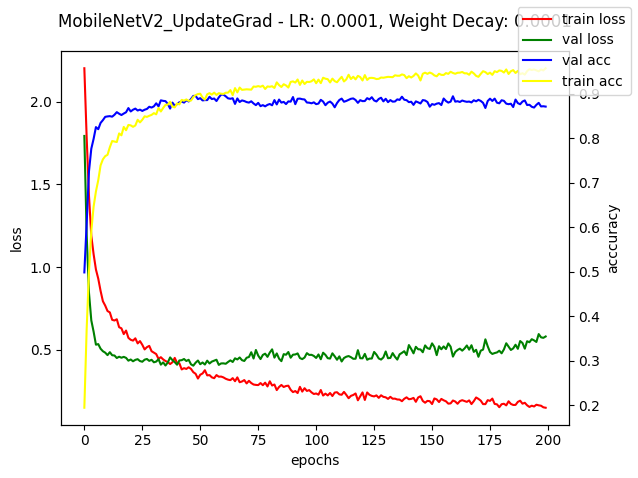

Validation Accuracy: 0.87109375
Test Accuracy: 0.88425


In [67]:
model=MobileNetV2_UpdateGrad(lr=0.0001,optimizer_type='Adam',weight_decay=0.0001,device=device)
model.to(device)
train_losses,val_losses,train_acc,val_acc=model.fit(train_loader=train_loader,nr_epochs=200,val_loader=val_loader,verbose=True,print_interval=10)
plotTrace(train_losses,val_losses,train_acc,val_acc,0.0001,0.0001,'MobileNetV2_UpdateGrad',200)
print(f'Validation Accuracy: {val_acc[-1]}')
test_acc=model.test(test_loader)
print(f'Test Accuracy: {test_acc}')

## Fine-Tuning Models Using Predefined Parameter Sets

In [50]:
learning_rates = [0.0001, 0.0005, 0.005, 0.05, 0.1]
weight_decays = [0.0001, 0.0005, 0.005, 0.05, 0.1]
best_accuracy = 0
best_lr = None
best_wd = None

for lr in learning_rates:
    for wd in weight_decays:
        # model = LogisticRegression(lr=lr, weight_decay=wd, optimizer_type='SGD', device=device)
        # model = FCNN(lr=lr, weight_decay=wd,num_hidden=3, optimizer_type='Adam', device=device)
        # model = CNN(lr=lr, weight_decay=wd, optimizer_type='Adam', device=device)
        # model = MobileNetV2_NoGrad(lr=lr, weight_decay=wd, optimizer_type='Adam', device=device)
        model = MobileNetV2_UpdateGrad(lr=lr, weight_decay=wd, optimizer_type='Adam', device=device)
        model.to(device)

        # Fit model (you might need to adjust these parameters or function calls)
        train_losses, val_losses, train_accuracy, val_accuracy = model.fit(train_loader, nr_epochs=30, val_loader=val_loader,print_interval=5)

        # Evaluate the model; here we assume the best model has the highest validation accuracy
        current_accuracy = max(val_accuracy)  # Taking the max of validation accuracy list
        print(f'Tested with LR: {lr}, WD: {wd}, Val Accuracy: {current_accuracy}')

        # Update best parameters
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_lr = lr
            best_wd = wd

print(f'Best Accuracy: {best_accuracy}, Best LR: {best_lr}, Best WD: {best_wd}')

Epoch 5: Train Loss: 1.0736, Val Loss: 0.5945
Epoch 10: Train Loss: 0.7738, Val Loss: 0.4680
Epoch 15: Train Loss: 0.6658, Val Loss: 0.4390
Epoch 20: Train Loss: 0.5938, Val Loss: 0.4136
Epoch 25: Train Loss: 0.5425, Val Loss: 0.4141
Epoch 30: Train Loss: 0.4978, Val Loss: 0.3836
Tested with LR: 0.0001, WD: 0.0001, Val Accuracy: 0.8785156272351742
Epoch 5: Train Loss: 1.0839, Val Loss: 0.5866
Epoch 10: Train Loss: 0.7858, Val Loss: 0.4603
Epoch 15: Train Loss: 0.6868, Val Loss: 0.4193
Epoch 20: Train Loss: 0.5900, Val Loss: 0.4297
Epoch 25: Train Loss: 0.5152, Val Loss: 0.4333
Epoch 30: Train Loss: 0.4900, Val Loss: 0.4277
Tested with LR: 0.0001, WD: 0.0005, Val Accuracy: 0.8783203139901161
Epoch 5: Train Loss: 1.0841, Val Loss: 0.6317
Epoch 10: Train Loss: 0.8065, Val Loss: 0.4736
Epoch 15: Train Loss: 0.6836, Val Loss: 0.4598
Epoch 20: Train Loss: 0.6104, Val Loss: 0.4065
Epoch 25: Train Loss: 0.5343, Val Loss: 0.3998
Epoch 30: Train Loss: 0.4993, Val Loss: 0.4245
Tested with LR: 0.0